## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [30]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [31]:
# Random state seed
rseed = 42

## Load and explore data

The data has a shape (164, 10) which means it has a 164 rows and 10 columns. The datatypes are appropriate for the data they present. There are no missing values. The summary statistics provide insights into the central tendency and variability of each variable. Additionally, all variables have the same number of data points.

In [32]:
# Import the dataset
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [33]:
# Check the shape
df.shape

(167, 10)

In [34]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [35]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [36]:
# Identify any missing data
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [37]:
# Drop any non-numeric features (columns)
df = df.drop('country', axis=1)

Text(0.5, 1.0, 'Correlation Heatmap')

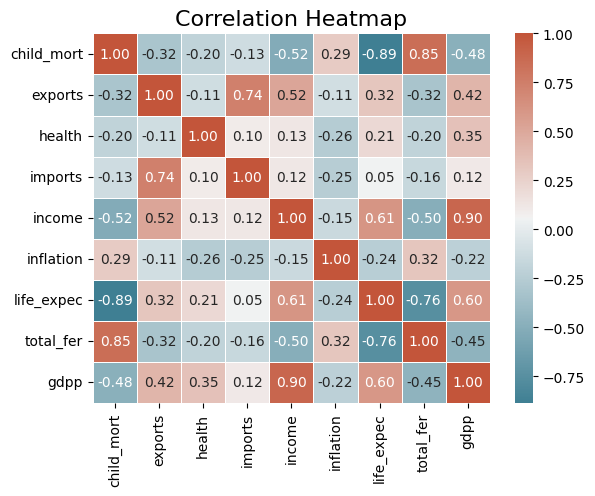

In [38]:
# Create a correlation map of features to explore relationships between features
# Define a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap=cmap, linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)

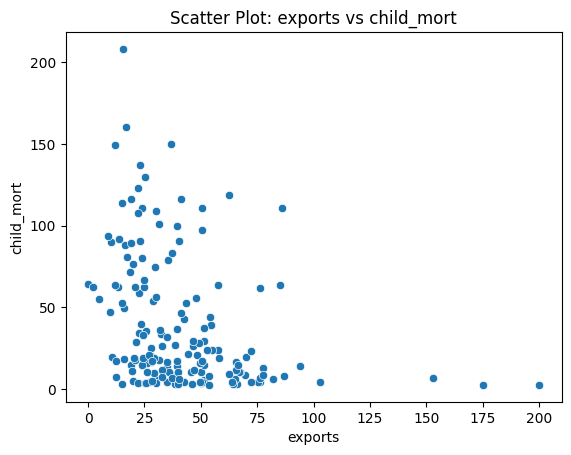

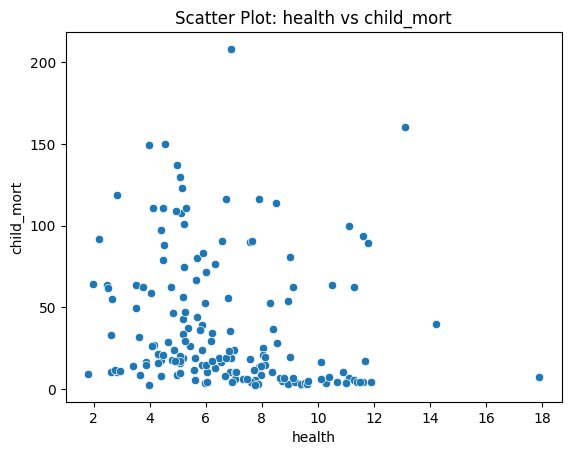

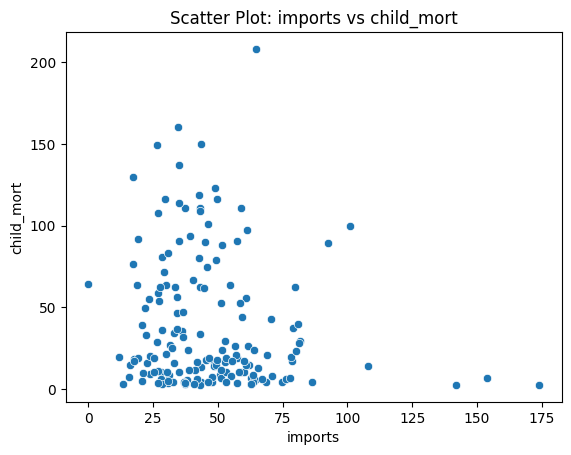

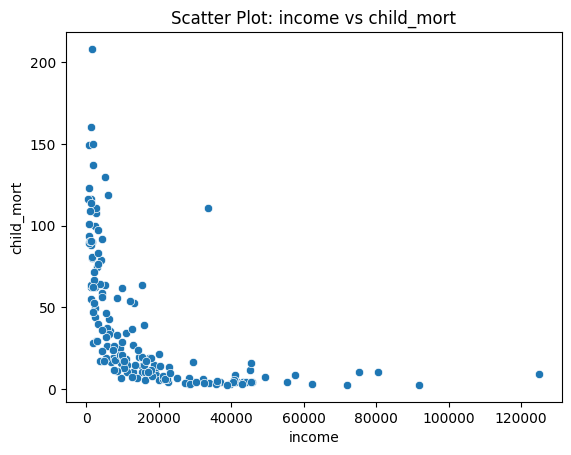

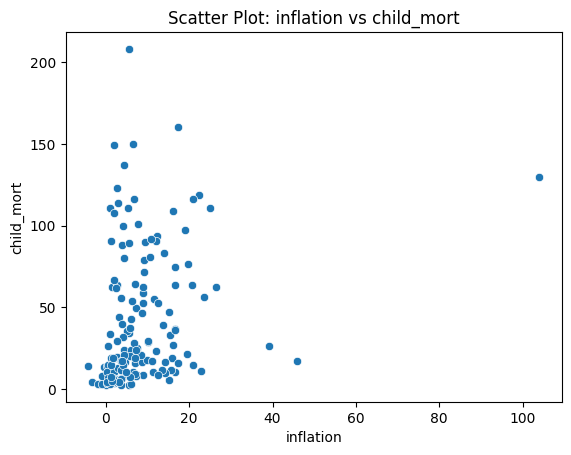

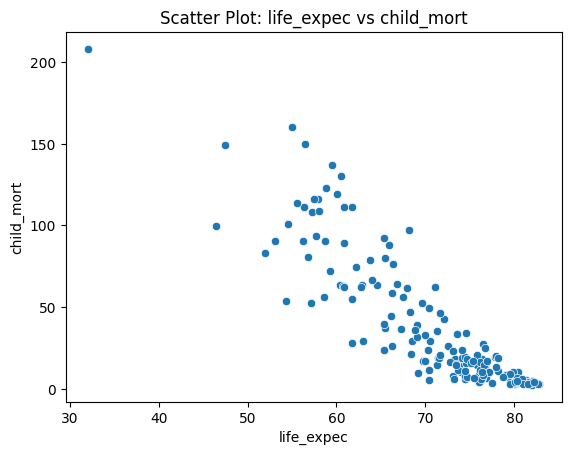

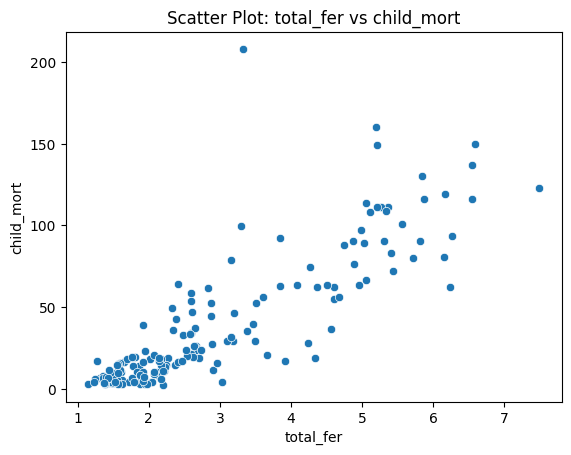

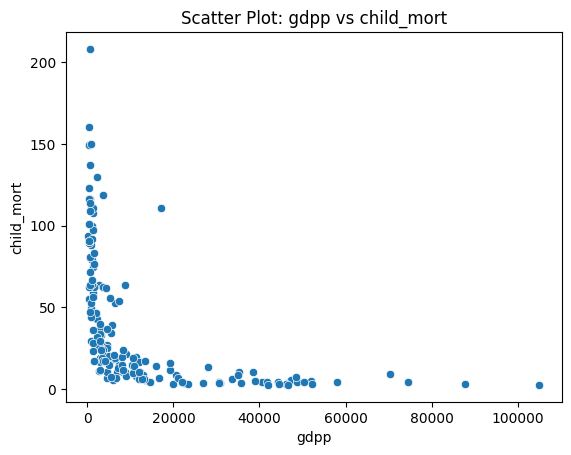

In [39]:
# Explore the continuous independent features against child_mort using scatter plots.

# Select all columns except the 'child_mort' column
features_to_explore = df.iloc[:,1:]

for feature in features_to_explore:
    sns.scatterplot(x=feature, y=df['child_mort'], data=df)
    plt.title(f'Scatter Plot: {feature} vs child_mort')
    plt.show()

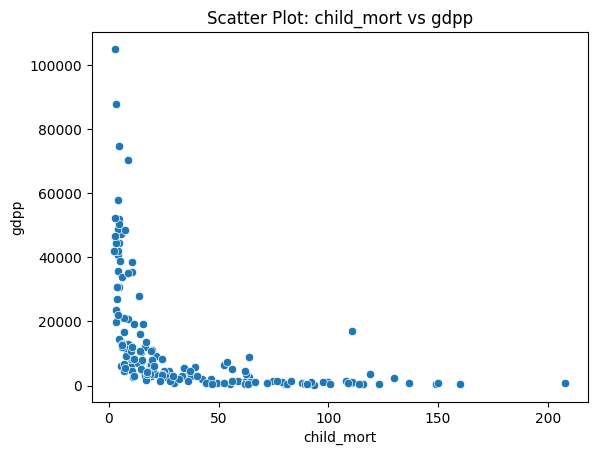

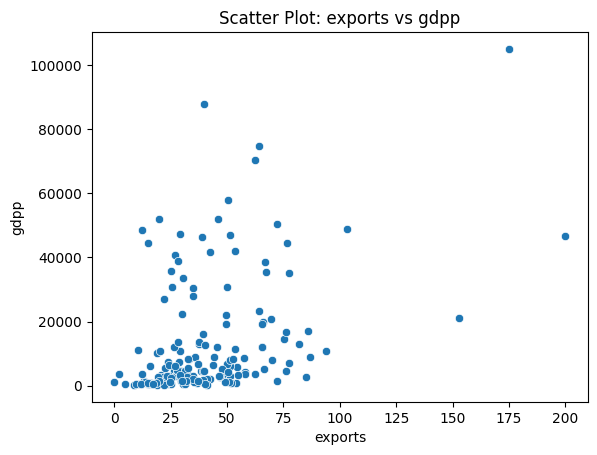

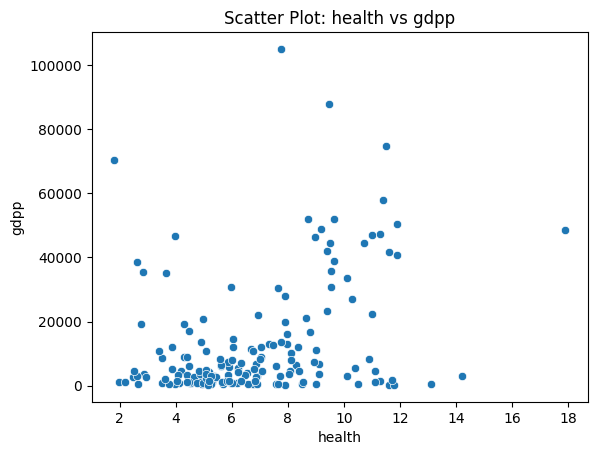

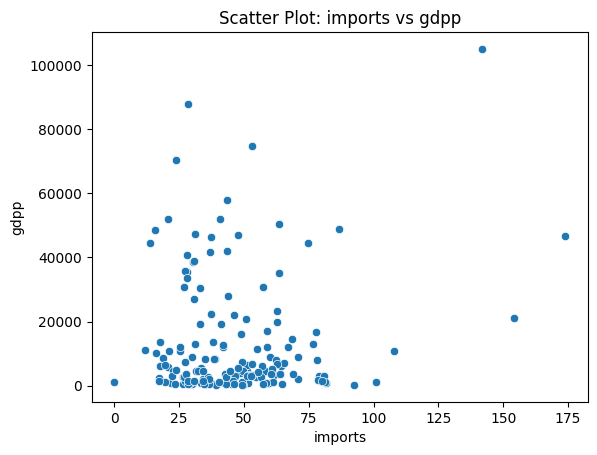

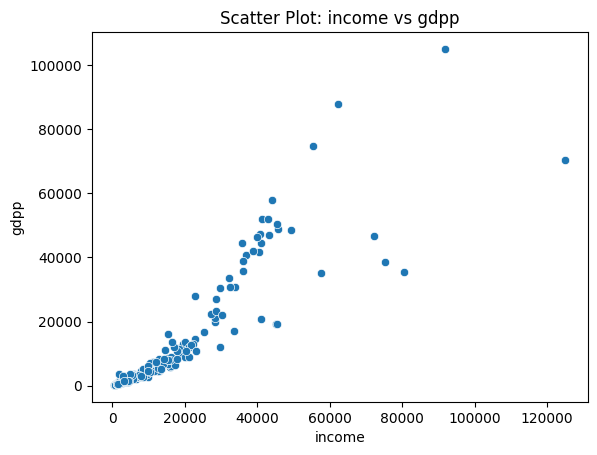

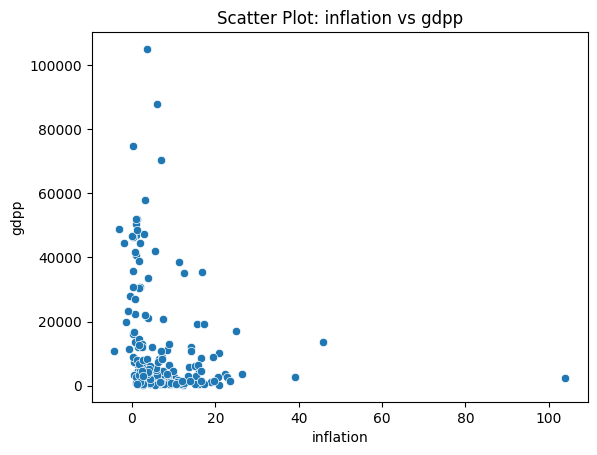

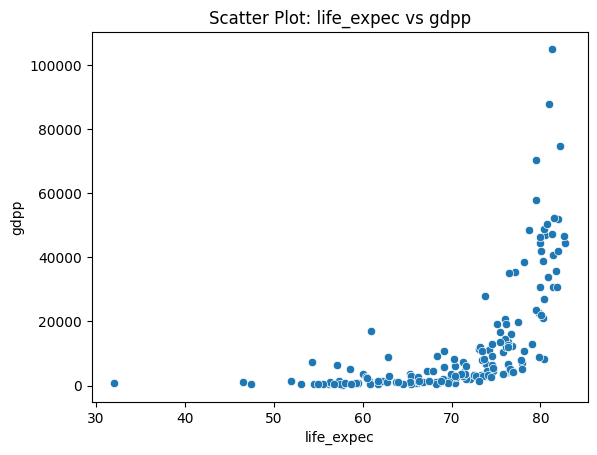

In [40]:
# Explore the continuous independent features against gdpp using scatter plots.

# Select all columns except the 'gdpp' column
features_to_explore = df.iloc[:,0:7]

for feature in features_to_explore:
    sns.scatterplot(x=feature, y=df['gdpp'], data=df)
    plt.title(f'Scatter Plot: {feature} vs gdpp')
    plt.show()

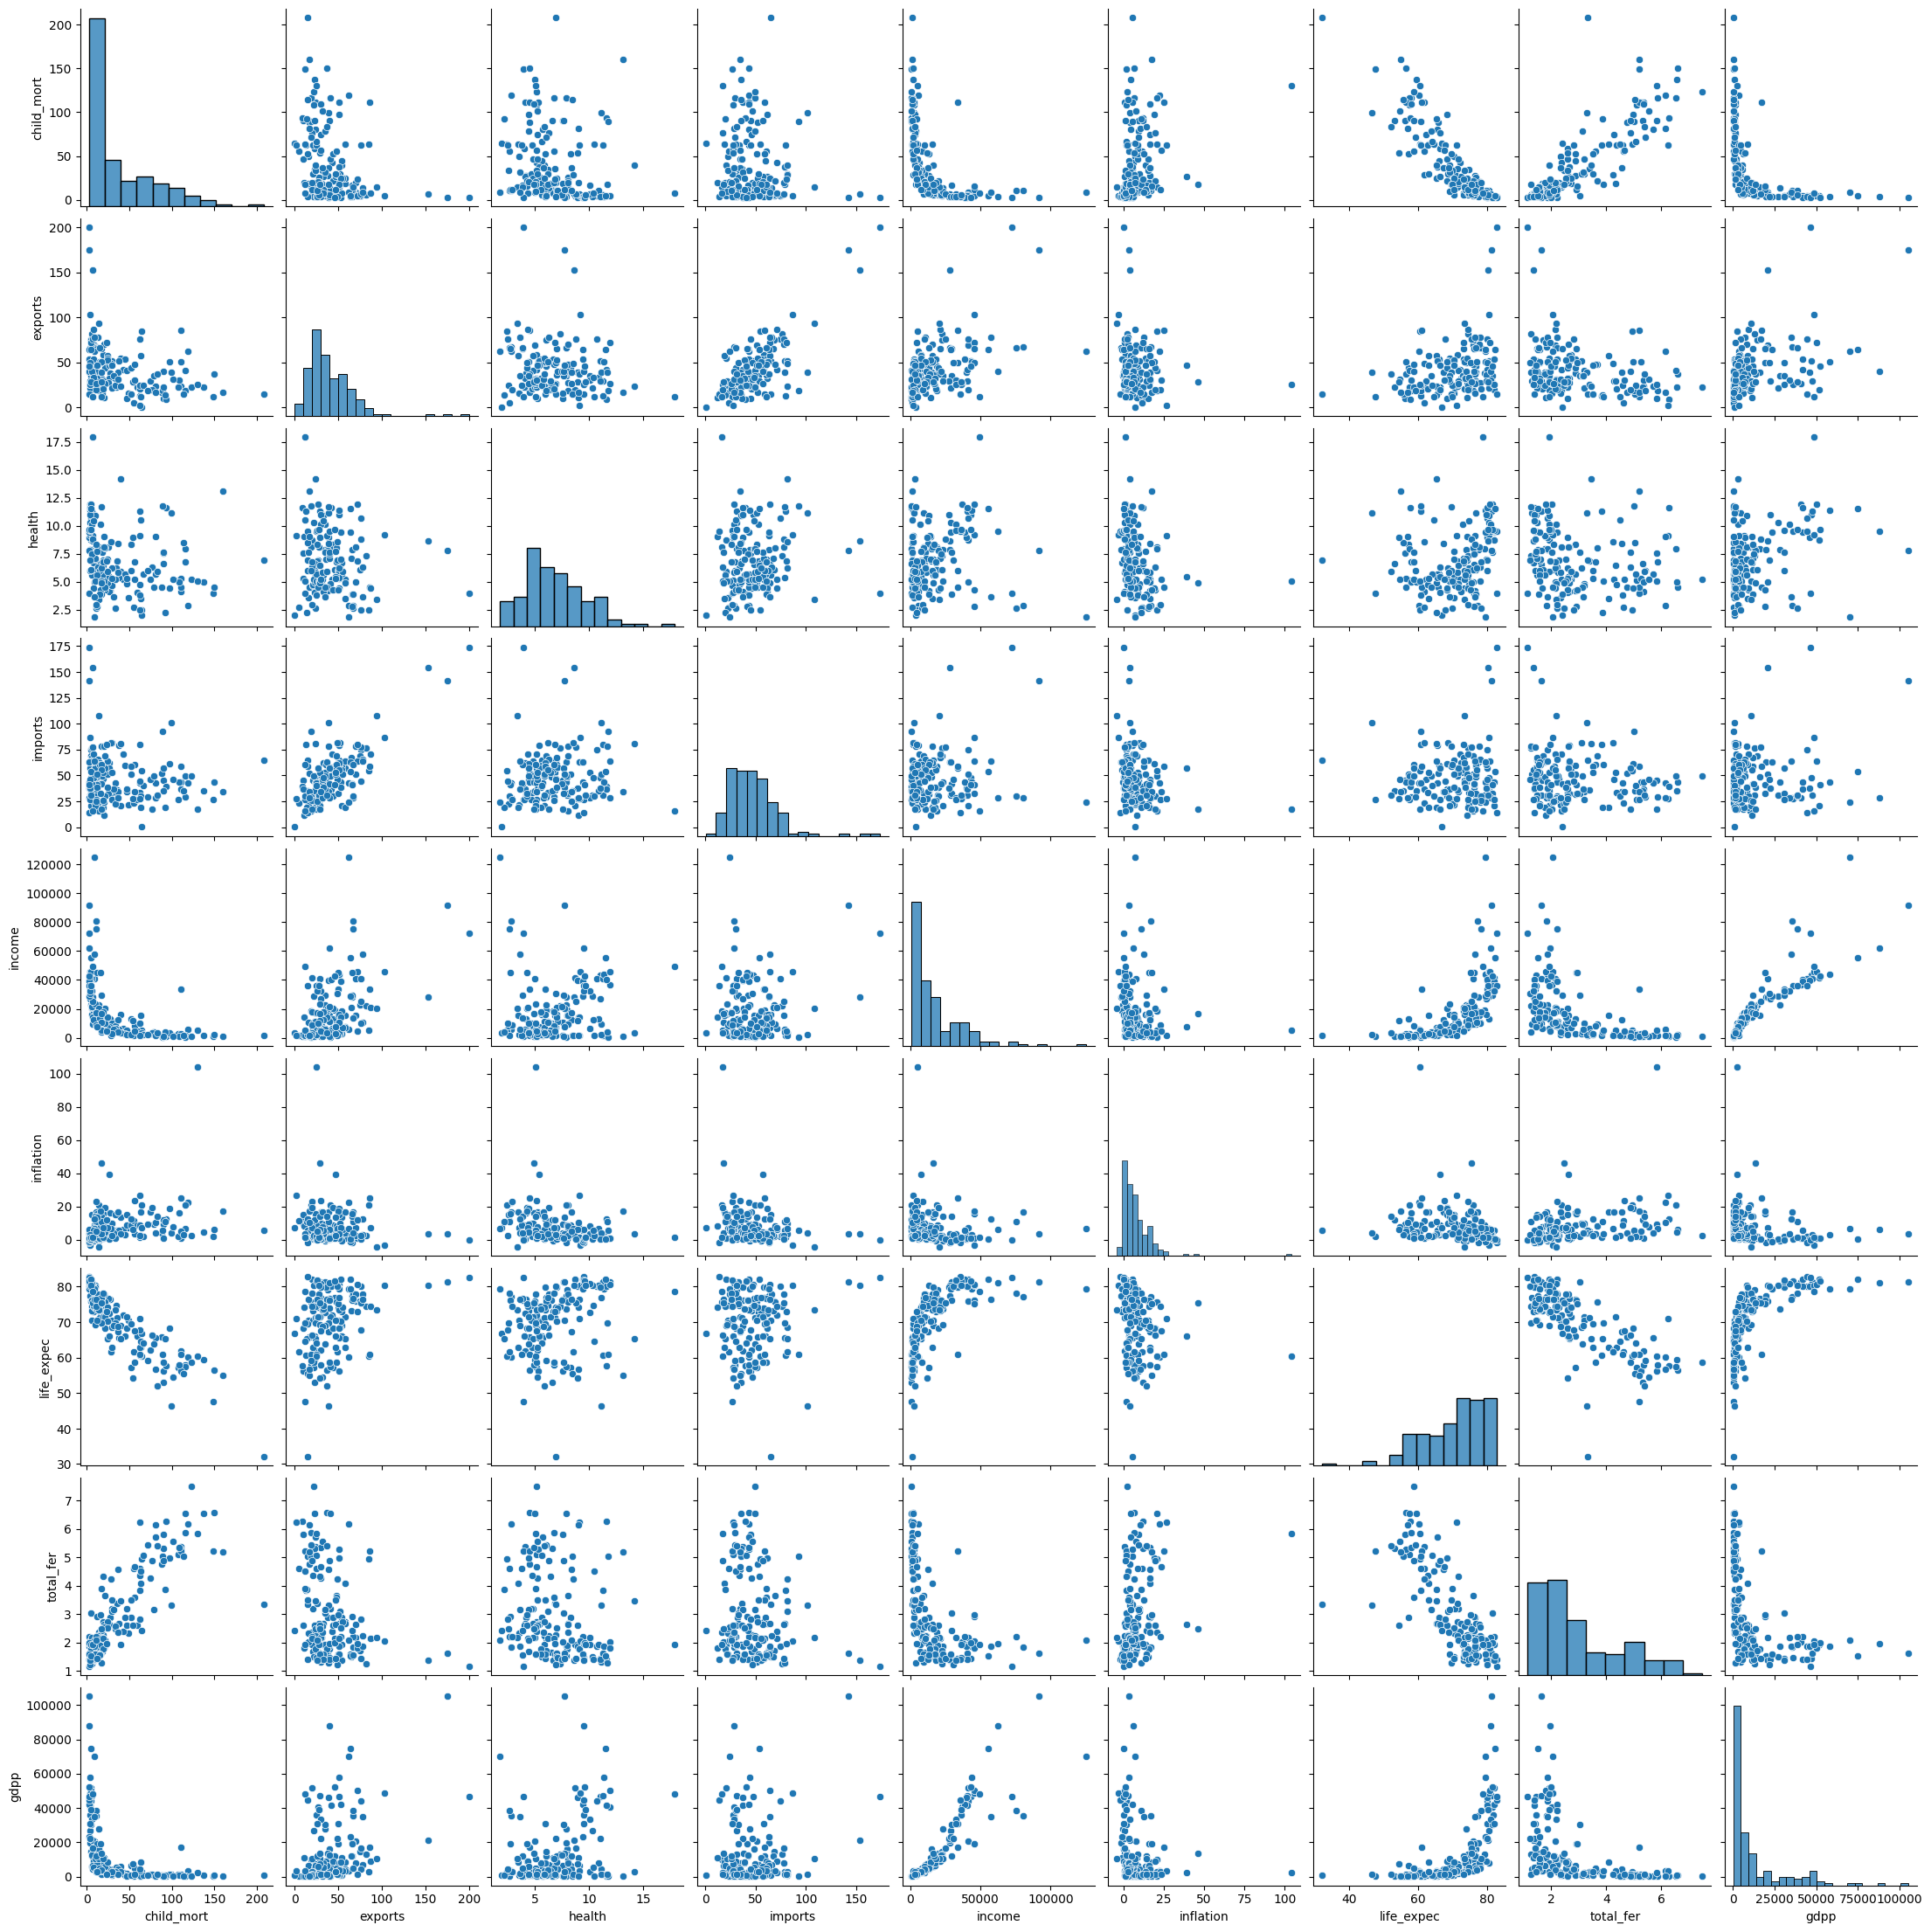

In [41]:
# Create a pair plot

sns.pairplot(df)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [42]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

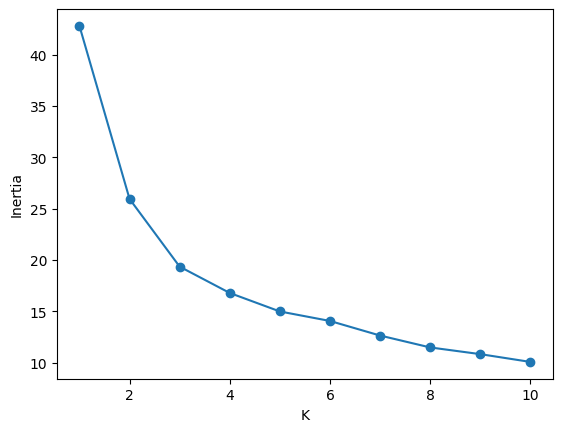

In [43]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset
eval_Kmeans(df_scaled, 6, 42) 
elbow_Kmeans(df_scaled)


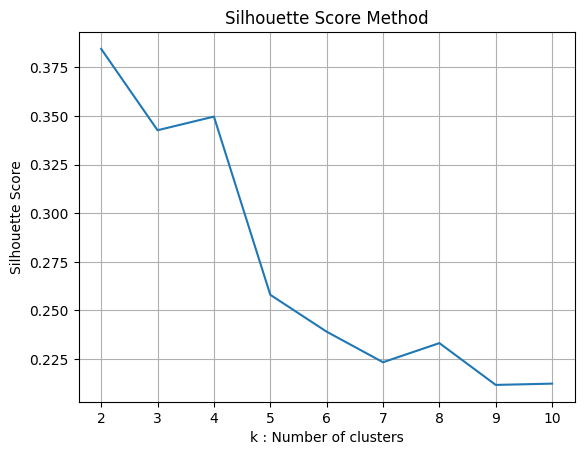

In [44]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

There is a huge reduction in variance after k=3 on the Elbow score method, which suggests that there might be three distinct clusters. Rounding down the highest Silhouette score to 0.3, ignoring the decimal places, gives a value of k=3. A score of 0.3 is reasonable, but it's generally considered modest. Given that both methods point to k=3 and that a silhouette score of 0.3 is acceptable, choosing k=3 seems reasonable in this case. It aligns with the observation of a significant reduction in variance at k=3 and a relatively high silhouette score, indicating a reasonable separation between clusters.

## Fitting a K-Means Model with the selected K value

In [45]:
# Remember to set the random_state to rseed

# Initialize KMeans model with the selected value of k
kmeans_model = KMeans(n_clusters=3, random_state=rseed)

# Fit the model to the data
kmeans_model.fit(df_scaled)

# Add the cluster labels to the original DataFrame
df_scaled['cluster_label'] = kmeans_model.labels_+1

# Display the DataFrame with cluster labels
print(df_scaled)

     child_mort   exports    health  ...  total_fer      gdpp  cluster_label
0      0.426485  0.049482  0.358608  ...   0.736593  0.003073              1
1      0.068160  0.139531  0.294593  ...   0.078864  0.036833              2
2      0.120253  0.191559  0.146675  ...   0.274448  0.040365              2
3      0.566699  0.311125  0.064636  ...   0.790221  0.031488              1
4      0.037488  0.227079  0.262275  ...   0.154574  0.114242              2
..          ...       ...       ...  ...        ...       ...            ...
162    0.129503  0.232582  0.213797  ...   0.370662  0.026143              2
163    0.070594  0.142032  0.192666  ...   0.208202  0.126650              2
164    0.100779  0.359651  0.312617  ...   0.126183  0.010299              2
165    0.261441  0.149536  0.209447  ...   0.555205  0.010299              1
166    0.391918  0.184556  0.253574  ...   0.670347  0.011731              1

[167 rows x 10 columns]


In [46]:
# Count the number of records in each cluster

df_scaled['cluster_label'].value_counts()

2    87
1    46
3    34
Name: cluster_label, dtype: int64

### Silhouette score

A silhouette coefficient of 0.6473 is quite high and close to 1. This suggests that the clusters are well defined, and each data point is appropriately assigned to its own cluster. High silhouette scores generally indicate good cluster formation. Therefore, a score of 0.6473 indicates strong cohesion within clusters and good separation between clusters.

In [47]:
# Check model performance with the silhouette coefficient
silhouette_score(df_scaled, df_scaled['cluster_label'])

0.6472950811485995

## Predictions

In [48]:
# Add the predicted cluster label column to the original dataframe

df['cluster_label'] = df_scaled['cluster_label']
print(df)

     child_mort  exports  health  ...  total_fer   gdpp  cluster_label
0          90.2     10.0    7.58  ...       5.82    553              1
1          16.6     28.0    6.55  ...       1.65   4090              2
2          27.3     38.4    4.17  ...       2.89   4460              2
3         119.0     62.3    2.85  ...       6.16   3530              1
4          10.3     45.5    6.03  ...       2.13  12200              2
..          ...      ...     ...  ...        ...    ...            ...
162        29.2     46.6    5.25  ...       3.50   2970              2
163        17.1     28.5    4.91  ...       2.47  13500              2
164        23.3     72.0    6.84  ...       1.95   1310              2
165        56.3     30.0    5.18  ...       4.67   1310              1
166        83.1     37.0    5.89  ...       5.40   1460              1

[167 rows x 10 columns]


## Visualisation of clusters

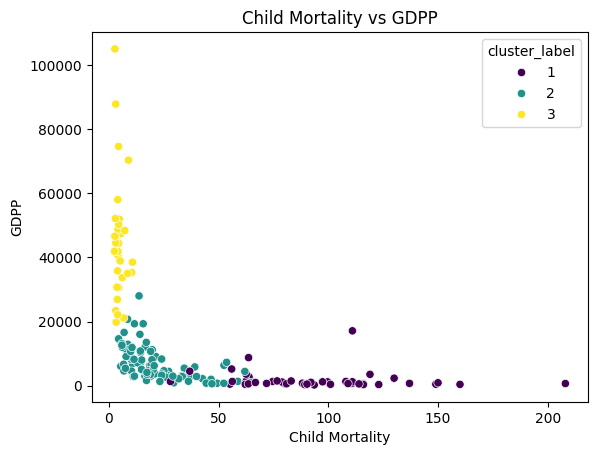

In [49]:
# Visualisation of clusters: child mortality vs gdpp

sns.scatterplot(x='child_mort', y='gdpp', hue='cluster_label', palette='viridis', data=df)
plt.title('Child Mortality vs GDPP')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.show()

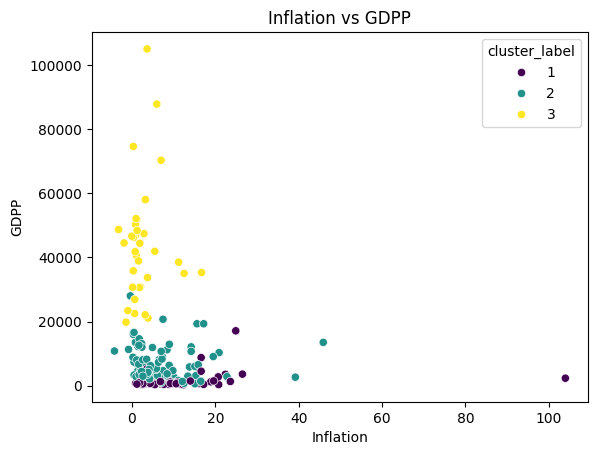

In [50]:
# Visualisation of clusters: inflation vs gdpp

sns.scatterplot(x='inflation', y='gdpp', hue='cluster_label', palette='viridis', data=df)
plt.title('Inflation vs GDPP')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.show()

## Conclusions

### Cluster Label 1- Least Developed Countries

The Child Moratlity vs GDPP scatterplot shows that countries with a low GDPP have high child mortality, This is indicative of a negative correlation between GDPP and child mortality (-0.48 from the correlation matrix). The outlier exceeding 200 likely represents a country facing severe challenges in healthcare, infrastructure, or socio-economic conditions, leading to exceptionally high child mortality. The concentration of points in the lower GDPP range suggests that the most affected countries in terms of child mortality are often those with lower economic development, supporting the notion that economic conditions can significantly impact healthcare outcomes for children.

The Inflation vs GDPP scatterplot suggest that least developed countries have a low GDPP and a high inflation rate, this is evident by the cluster of points at the bottom of the graph and an outlier of Inflation greater than 100. This outlier might represent a country experiencing hyperinflation or economic instability, which can have profound implications for its economic development.

### Cluster Label 2- Developing Countries

Label 2 in the Child Mortality and GDPP scatterplot is found to be in the middle of label 1 and label 3 with a few overlapping data points. Child Mortality is low and the GDPP is a bit higher than the data points in label 3. This suggests that countries in Cluster Label 2 can be characterised as developing countries. While they have a somewhat higher GDPP than the least developed countries (Label 3), their Child Mortality rates are still relatively low. This indicates a positive trend where these developing countries have made progress in healthcare and resource allocation

The Inflation vs GDPP scatterplot shows a cluster of datapoints directly above label 3. This indicates a higher GDPP and a low inflation rate. This positioning suggests that the countries in Cluster Label 2 can be associated with developing countries. They exhibit a higher GDPP and a lower inflation rate, indicating relative economic stability. The presence of outliers may signify specific cases of economic challenges within this cluster.

### Cluster Label 3- Developed Countries

Cluster Label 3 on the Child Mortality vs GDPP shows countries with low Child Mortality and high GDPP. The combination of low Child Mortality and high GDPP strongly suggests that the countries in Cluster Label 3 are associated with developed nations. These countries likely have well-established healthcare systems and robust economies, contributing to better child health outcomes. 

We see the same trend in the Inflation vs GDPP scatterplot; there is a high GDPP with low inflation. The trend of high GDPP and low inflation in Cluster Label 3 further supports the association of these countries with developed nations. Developed countries often exhibit economic stability and lower inflation rates due to effective monetary and fiscal policies.